In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tf
from PIL import Image

import numpy as np
import pandas as pd

IMG_SIZE = 512

class TurtleRecallDataset(Dataset):
    def __init__(self, path_to_file, path_to_imgs, transforms=None):
        dataframe = pd.read_csv(path_to_file)
        self.path_to_imgs = path_to_imgs
        self.images = np.array(path_to_imgs + '/' + dataframe.image_id + '.JPG')
        self.transforms = transforms
        self.images_id = dataframe.image_id
        self.image_locations = []

        if 'turtle_id' in dataframe:
            self.turtle_ids = np.array(dataframe.turtle_id)
            self.targets = np.zeros(len(self.turtle_ids), dtype=np.uint32)
            for target, turtle_id in enumerate(np.unique(self.turtle_ids)):
                self.targets[turtle_id == self.turtle_ids] = target

        if 'image_location' in dataframe:
            self.image_locations = np.array(dataframe.image_location)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        w, h = image.size
        crop_size = min(w, h)
        image = image.crop(
            (
                (w - crop_size) // 2,
                (h - crop_size) // 2,
                (w + crop_size) // 2,
                (h + crop_size) // 2,
            )
        )
        if self.transforms:
            image = self.transforms(image)
        image = np.array(image)
        return image

In [2]:
"""
Reading train and extra images into numpy array
"""

transforms = tf.Compose([tf.Resize((IMG_SIZE, IMG_SIZE))])

def read_dataset(path_to_csv, path_to_imgs):
    dataset = TurtleRecallDataset(path_to_file=path_to_csv,
                                  path_to_imgs=path_to_imgs,
                                  transforms=transforms)
    dataloader = DataLoader(dataset, batch_size=512, num_workers=8, shuffle=False)
    images = np.concatenate([img for img in dataloader])
    targets = dataset.targets
    image_locations = np.array([x.lower() for x in dataset.image_locations])
    turtle_ids = dataset.turtle_ids

    return {
        'images': images,
        'targets': targets,
        'image_location': image_locations,
        'turtle_id': turtle_ids,
    }

train_set = read_dataset('../data/train.csv', '../data/images')
extra_set = read_dataset('../data/extra_images.csv', '../data/images')
print(f"Train set size {train_set['images'].shape}")
print(f"Extra set size {extra_set['images'].shape}")

Train set size (2145, 512, 512, 3)
Extra set size (10658, 512, 512, 3)


In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.utils import make_grid
from torchvision import models

import matplotlib.pyplot as plt
import torch.nn as nn
import torch

"""
Now, we are going to try to remove duplicated images using cosine similarity
between generated embeddings by trained backbones
"""

def find_duplicated_pairs(
    encoders,
    all_images,
    all_targets,
    threshold=0.9,
    device='cuda:0',
):
    transforms = tf.Compose([
        tf.ToTensor(),
        tf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    duplicated_pairs = {}

    for name, encoder in encoders:
        encoder = encoder.to(device)
        encoder.requires_grad_(False)
        print(f'{name} encoder')
        for target in np.unique(all_targets):
            imgs = all_images[all_targets == target]
            imgs = [transforms(img) for img in imgs]
            imgs = torch.stack(imgs).to(device)
            embeddings = torch.flatten(encoder(imgs), 1)
            embeddings = embeddings.cpu().numpy()
            similarity = cosine_similarity(embeddings)
            similarity[np.eye(len(embeddings), dtype='bool')] = 0
            mask = np.triu(np.where(similarity > threshold, True, False))
            xs, ys = np.where(mask)
            if len(xs):
                if not target in duplicated_pairs:
                    duplicated_pairs[target] = []
                for x, y in zip(xs, ys):
                    if not (x, y) in duplicated_pairs[target]:
                        duplicated_pairs[target].append((x, y))
    return duplicated_pairs


"""
Try to find and delete possible outliers using cosine similarity
between embeddings, discard embeddings whose cosine similarity is lower than
a set threshold
"""
def find_outliers(
    encoders,
    all_images,
    all_targets,
    threshold=0.8,
    device='cuda:0',
):
    transforms = tf.Compose([
        tf.ToPILImage(),
        tf.RandomEqualize(p=1),
        tf.ToTensor(),
        tf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    outliers = {}

    for name, encoder in encoders:
        encoder = encoder.to(device)
        encoder.eval()
        encoder.requires_grad_(False)
        print(f'{name} encoder')
        for target in np.unique(all_targets):
            imgs = all_images[all_targets == target]
            imgs = [transforms(img) for img in imgs]
            imgs = torch.stack(imgs).to(DEVICE)
            embeddings = torch.flatten(encoder(imgs), 1).cpu().numpy()
            similarity = np.mean(cosine_similarity(embeddings), axis=1)
            indices = np.flatnonzero(all_targets == target)[similarity < threshold]
            if len(indices):
                if not target in outliers:
                    outliers[target] = []
                outliers[target].extend(indices)
                outliers[target] = list(np.unique(outliers[target]))

    return outliers

resnet101 encoder
Total of duplicated pairs: 30


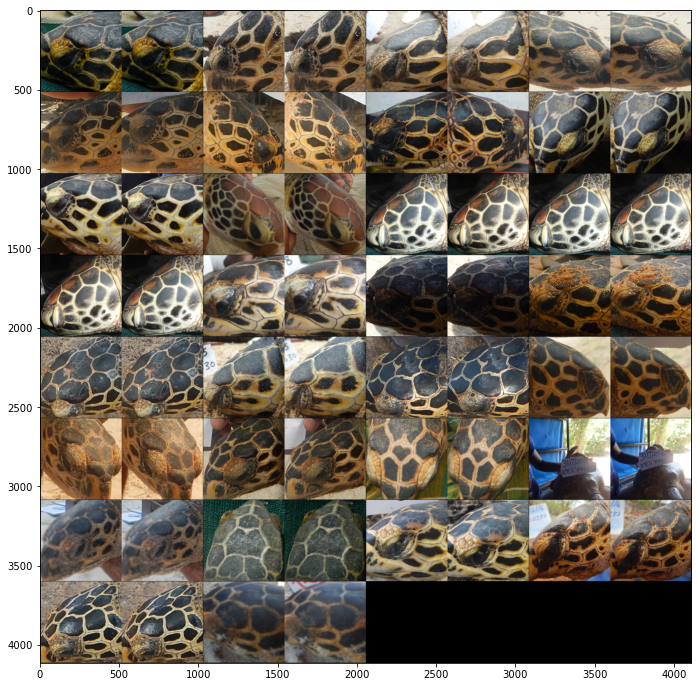

In [4]:
"""
Now, we are going to try to remove duplicated images using cosine similarity
between generated embeddings by trained backbones
"""
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.utils import make_grid
from torchvision import models

import matplotlib.pyplot as plt
import torch.nn as nn
import torch

THRESHOLD = 0.96
DEVICE = 'cuda:0'

train_images = train_set['images']
train_targets = train_set['targets']
train_image_locations = train_set['image_location']
train_turtle_ids = train_set['turtle_id']

encoders = [
    ('resnet101', nn.Sequential(*list(models.resnet101(pretrained=True).children())[:-1])),
]

duplicated_pairs = find_duplicated_pairs(
    encoders,
    train_images,
    train_targets,
    threshold=THRESHOLD,
    device=DEVICE
)

pair_imgs = np.array([
    np.concatenate(
        [
            train_images[train_targets == target][pair[0]],
            train_images[train_targets == target][pair[1]],
        ],
        axis=1
    )
    for target in duplicated_pairs
    for pair in duplicated_pairs[target]
])

print(f'Total of duplicated pairs: {len(pair_imgs)}')

batch = torch.from_numpy(pair_imgs).permute(0, 3, 1, 2)
grid = make_grid(batch, nrow=4)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0))

In [5]:
"""
Randomly choose one image from duplicated pairs
"""
import random

random.seed(42)

indices_to_delete = []
for k in duplicated_pairs:
    indices = np.flatnonzero(train_targets == k)
    for pair in duplicated_pairs[k]:
        indices_to_delete.append(indices[random.choice(pair)])

train_images = np.delete(train_images, indices_to_delete, axis=0)
train_targets = np.delete(train_targets, indices_to_delete, axis=0)
train_turtle_ids = np.delete(train_turtle_ids, indices_to_delete, axis=0)
train_image_locations = np.delete(train_image_locations, indices_to_delete, axis=0)

print(f'Total of deleted images: {len(indices_to_delete)}')

Total of deleted images: 30


resnet152 encoder
Total of outliers: 50


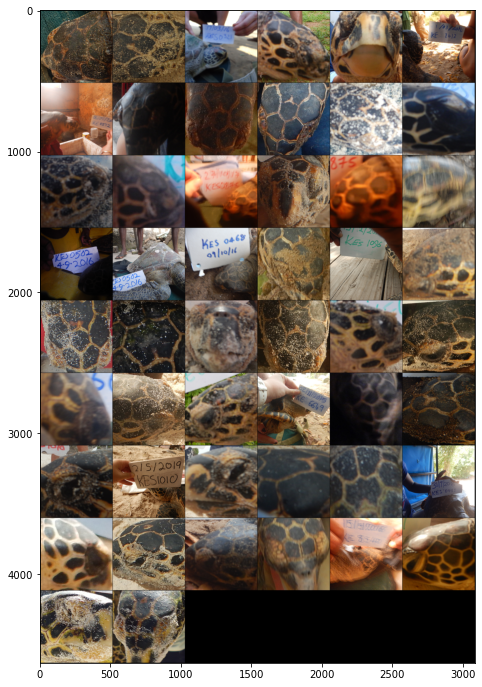

In [6]:
THRESHOLD = 0.845
DEVICE = 'cuda:0'

encoders = [
    ('resnet152', nn.Sequential(*list(models.resnet152(pretrained=True).children())[:-1])),
]

outliers = find_outliers(
    encoders,
    train_images,
    train_targets,
    threshold=THRESHOLD,
    device=DEVICE
)

indices_to_delete = np.concatenate(list(outliers.values()))
outlier_imgs = train_images[indices_to_delete]
print(f'Total of outliers: {len(outlier_imgs)}')

batch = torch.from_numpy(outlier_imgs).permute(0, 3, 1, 2)
grid = make_grid(batch, nrow=6)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0))

In [7]:
import pickle

train_images = np.delete(train_images, indices_to_delete, axis=0)
train_targets = np.delete(train_targets, indices_to_delete, axis=0)
train_turtle_ids = np.delete(train_turtle_ids, indices_to_delete, axis=0)
train_image_locations = np.delete(train_image_locations, indices_to_delete, axis=0)

train_dataset = {
    'images': train_images,
    'labels': train_targets,
    'turtle_id': train_turtle_ids,
    'image_location': train_image_locations,
}

with open('../data/train_384_384', 'wb') as handle:
    pickle.dump(train_dataset, handle)

resnet152 encoder
Total of duplicated pairs: 228


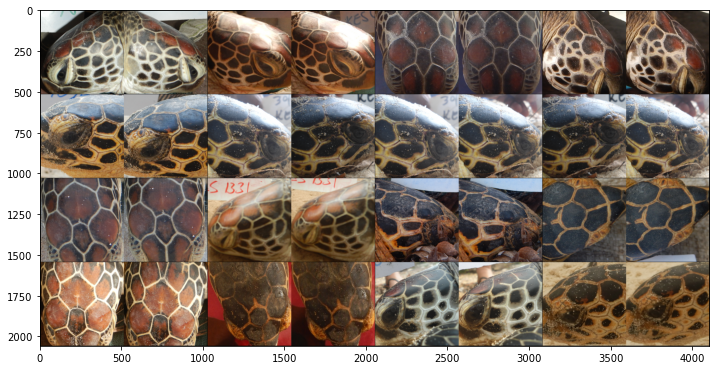

In [8]:
from torchvision.utils import make_grid
from torchvision import models
import matplotlib.pyplot as plt

import torch.nn as nn


THRESHOLD = 0.95
DEVICE = 'cuda:0'

encoders = [
    ('resnet152', nn.Sequential(*list(models.resnet152(pretrained=True).children())[:-1]))
]

extra_images = extra_set['images']
extra_targets = extra_set['targets']
extra_turtle_ids = extra_set['turtle_id']

duplicated_pairs = find_duplicated_pairs(
    encoders,
    extra_images,
    extra_turtle_ids,
    threshold=THRESHOLD,
    device=DEVICE
)

pair_imgs = np.array([
    np.concatenate(
        [
            extra_images[extra_turtle_ids == target][pair[0]],
            extra_images[extra_turtle_ids == target][pair[1]],
        ],
        axis=1
    )
    for target in duplicated_pairs
    for pair in duplicated_pairs[target]
])

print(f'Total of duplicated pairs: {len(pair_imgs)}')

batch = torch.from_numpy(pair_imgs).permute(0, 3, 1, 2)[:16]
grid = make_grid(batch, nrow=4)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0))

In [9]:
"""
Randomly choose one image from duplicated pairs
"""
import random

random.seed(42)

indices_to_delete = []
for k in duplicated_pairs:
    indices = np.flatnonzero(extra_turtle_ids == k)
    for pair in duplicated_pairs[k]:
        indices_to_delete.append(indices[random.choice(pair)])

extra_images = np.delete(extra_images, indices_to_delete, axis=0)
extra_targets = np.delete(extra_targets, indices_to_delete, axis=0)
extra_turtle_ids = np.delete(extra_turtle_ids, indices_to_delete, axis=0)

print(f'Total of deleted images: {len(indices_to_delete)}')

Total of deleted images: 228


resnet152 encoder
Total of outliers: 52


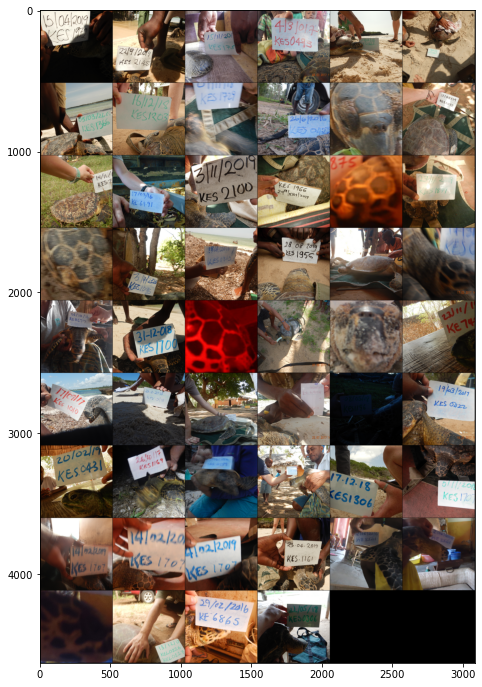

In [10]:
THRESHOLD = 0.8
DEVICE = 'cuda:0'

encoders = [
    ('resnet152', nn.Sequential(*list(models.resnet152(pretrained=True).children())[:-1])),
]

outliers = find_outliers(
    encoders,
    extra_images,
    extra_turtle_ids,
    threshold=THRESHOLD,
    device=DEVICE
)

indices_to_delete = np.concatenate(list(outliers.values()))
outlier_imgs = extra_images[indices_to_delete]
print(f'Total of outliers: {len(outlier_imgs)}')

batch = torch.from_numpy(outlier_imgs).permute(0, 3, 1, 2)
grid = make_grid(batch, nrow=6)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0))

In [11]:
import pickle

extra_images = np.delete(extra_images, indices_to_delete, axis=0)
extra_targets = np.delete(extra_targets, indices_to_delete, axis=0)
extra_turtle_ids = np.delete(extra_turtle_ids, indices_to_delete, axis=0)

extra_dataset = {
    'images': extra_images,
    'labels': extra_targets,
    'turtle_id': extra_turtle_ids,
}

with open('../data/extra_384_384', 'wb') as handle:
    pickle.dump(train_dataset, handle)